# Fundamentos de la Computación Cuántica - Tercera Entrega

Un multiplicador entre dos números binarios codificados en 3 qubits (mediante estados básicos), basado en dominio de Fourier

## Imports

In [33]:
import math
from qiskit import QuantumCircuit, transpile
from qiskit_aer import AerSimulator
from qiskit.visualization import plot_histogram

# Para la visualización de los resultados en tablas:
import os
import matplotlib.pyplot as plt # Utilizada para generación de tablas.

## Transformada Cuántica de Fourier Inversa (IQTF)

Por consiguiente, se plantea la transformada cuántica de Fourier inversa para N qubits.

![iqtf4.png](images/iqft4.png)

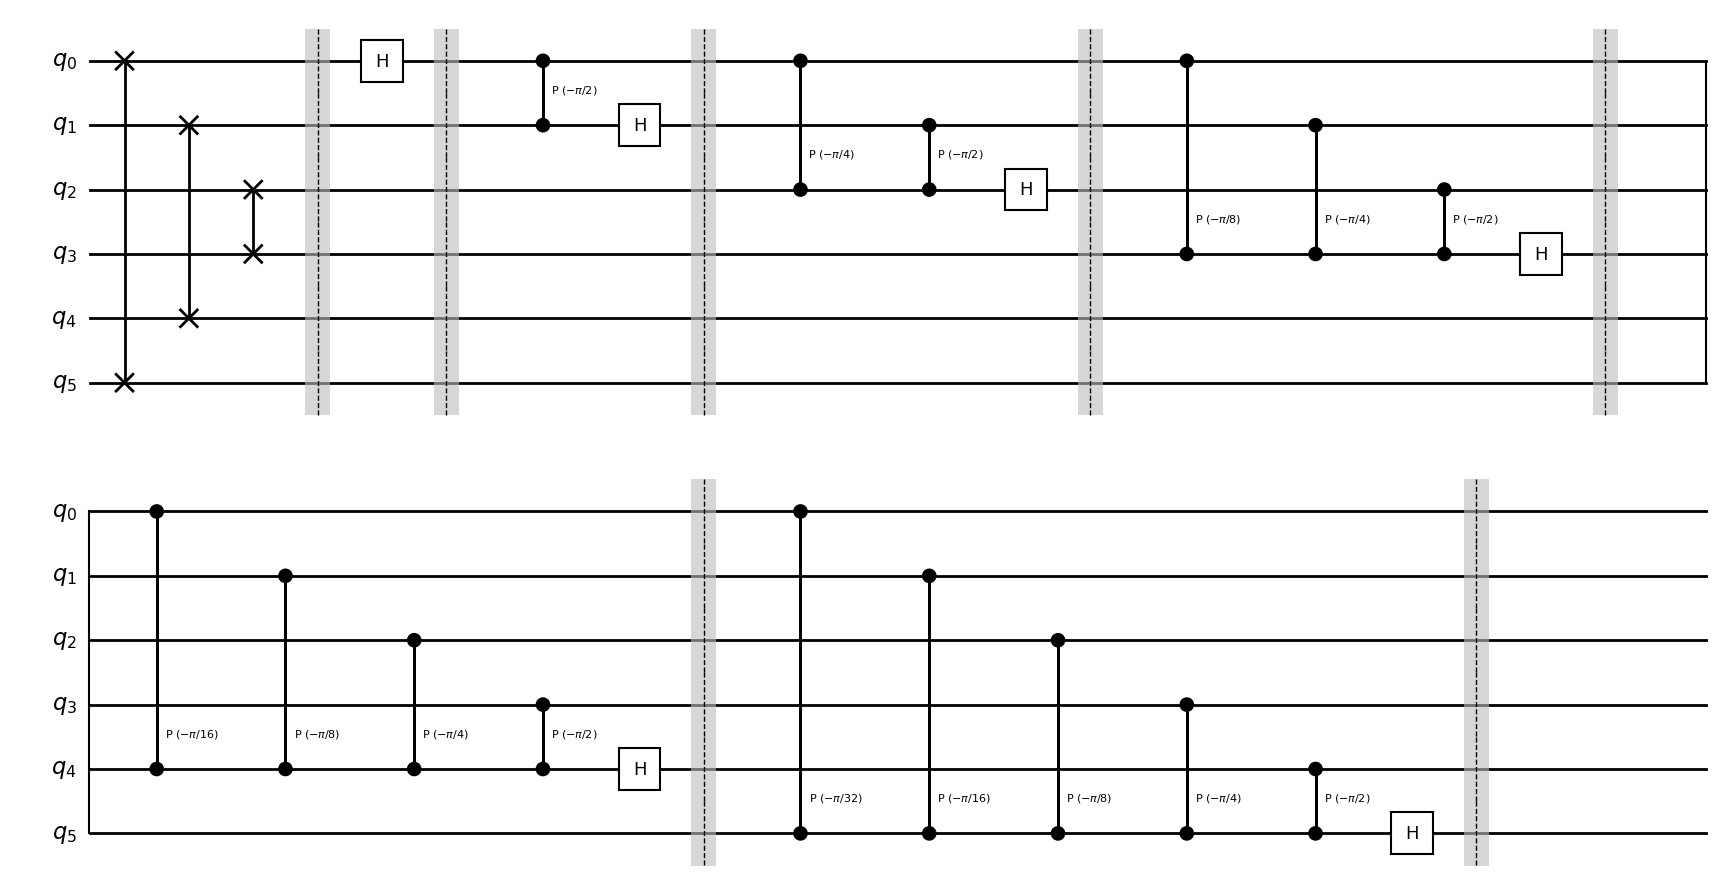

In [40]:
def iqtf(number_of_qubits):
    
    quantum_circuit = QuantumCircuit(number_of_qubits, name="IQTF")
    
    accesible_qubits = number_of_qubits - 1
    
    # Swap entre el qubit 0 y el n - 1.
    # Swap entre el qubit 1 y el n - 2.
    # Y así hasta llegar al centro.
    
    # Los swaps pueden ahorrarse si se invierte el orden de los qubits resultados.
    for i in range(int(number_of_qubits/2)):
        quantum_circuit.swap(i, accesible_qubits - i)
        
    quantum_circuit.barrier()
        
    # Por cada qubit, se aplica una rotación extra.
    # Al primer qubit, solo se le aplica Hadamard.
    # Al segundo, una rotación de pi/2 y Hadamard.
    # Al tercero, una rotación de pi/4, una rotación de pi/2 y Hadamard.
    for i in range(number_of_qubits):
        
        for j in range(i, 0, -1):
            # crz(angulo, control, objetivo)
            quantum_circuit.cp(-math.pi/(2 ** j), i - j, i)
        
        # Se aplica un Hadamard luego de las rotaciones.
        quantum_circuit.h(i)
        
        # Se aplica una barrera para evitar el autoordenamiento de Qiskit.
        quantum_circuit.barrier()
        
    return quantum_circuit
        
qc = iqtf(6)
qc.draw(output='mpl', style='bw')

## Multiplicador entre dos Números Binarios codificados en 3 qubits

El máximo número representable con 3 qubits es 7. El mayor valor obtenible de la multiplicación es 7 X 7 = 49. El cual puede representarse con seis qubits. 2^5 (32) + 2^4 (16) + 2^0 (1) = 110001. 

Las entradas serán x0, x1, x2, y0, y1, y2. De acuerdo al número dictaminano por y, es la cantidad de rotaciones que debo efectuar.
Si x0 está activo,

se debe sumar y0, y1 e y2.

Si x1 está activo,

se debe sumar y0, y1 e y2 dos veces.

Si x2 está activo,

se debe sumar y0, y1 e y2 cuatro veces.
La máxima multiplicación alcanzable es 7 x 7: 49. 6 qubits. 49 -> 2^5 (32) + 2^4 (16) + 2^0 (1). Lo que ocupa 6 qubits.

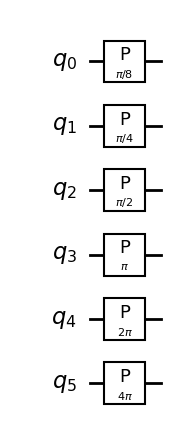

In [35]:
def plusN(n, result_qubits):
    
    # Creación del circuito.
    qc = QuantumCircuit(result_qubits, name=f"+{n}")
    
    for i in range(result_qubits):
        
        # Fórmula: Angulo Base * Valor
        angulo = (math.pi / (2 ** i)) * n
        
        # Aplicación de la rotación.
        qc.p(angulo, result_qubits - 1 - i) 
        
    return qc

plusN(4, 6).draw(output='mpl', style='bw')

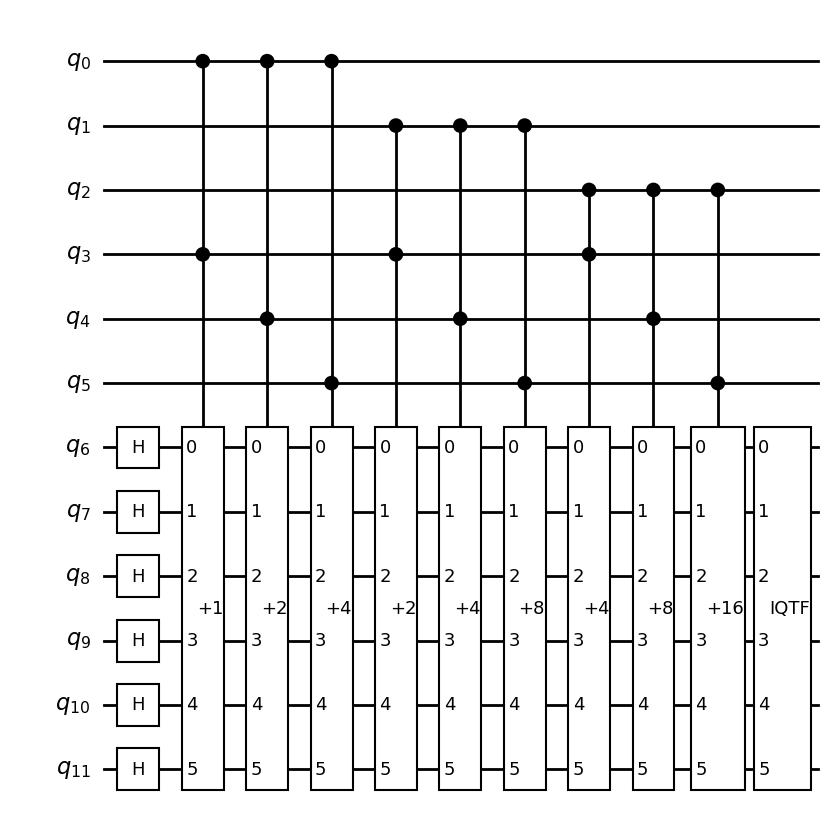

In [36]:
def multiplier(qubits_in_first_operand, qubits_in_second_operand=None):
    
    # Se asume que la cantidad de qubits en el segundo operando
    # es igual a la cantidad en el primer operando.
    if qubits_in_second_operand == None:
        qubits_in_second_operand = qubits_in_first_operand
    
    # En el peor de los casos, la multiplicación de un operando de m bits y un operando
    # de n bits tiene como resultado a un número de m + n bits.
    result_qubits = qubits_in_first_operand + qubits_in_second_operand
    
    # Qubits totales dirigidos a operandos.
    operands_qubits = qubits_in_first_operand + qubits_in_second_operand
    
    # Qubits totales en el circuito.
    total_qubits = operands_qubits + result_qubits
    
    # Creación del circuito.
    quantum_circuit = QuantumCircuit(total_qubits, name=f"MUL")
    
    # Aplicación de Hadamard a los qubits resultado.
    for i in range(operands_qubits, total_qubits, 1):
        quantum_circuit.h(i)
        
    # Lista de compuertas a descomponer.
    gates_to_descompose = []
    
    for i in range(qubits_in_first_operand):
        
        # Valor del i-ésimo qubit del primer operando.
        first_operand_value = 2 ** i
        
        for j in range(qubits_in_second_operand):
            
            # Valor del j-ésimo qubit del segundo operando.
            second_operand_value = 2 ** j
            
            # Resultado de la multiplicación de los operandos.
            value_to_sum = first_operand_value * second_operand_value
            
            # Creación de la compuerta de suma.
            sum_gate = plusN(value_to_sum, result_qubits)
            
            # La columna es controlada por dos qubits: Xi e Yj.
            controlled_gate = sum_gate.control(2)
            
            # Se añade la compuerta controlada a la lista de compuertas a descomponer.
            if controlled_gate.name not in gates_to_descompose:
                gates_to_descompose.append(controlled_gate.name)
        
            # Se definen los "cables": [ControlX, ControlY, Objetivo1, Objetivo2, Objetivo3...].
            qubit_control = [i, j + qubits_in_first_operand] #Xi y Yj, respectivamente.
            qubits_objetivo = list(range(operands_qubits, total_qubits)) # Qubits del acumulador.
            
            # Cableado.
            wiring = qubit_control + qubits_objetivo
            
            # Agregado de la compuerta al circuito.
            quantum_circuit.append(controlled_gate, wiring)
    
    # Se descomponen las compuertas con controles de forma que Qiskit no genere
    # automáticamente una caja negra y pueda verse claramente quién activa cada compuerta.
    quantum_circuit = quantum_circuit.decompose(gates_to_decompose=gates_to_descompose)
        
    # Se añade la transformada cuántica de Fourier inversa para decodificar el resultado.
    quantum_circuit.append(iqtf(result_qubits), list(range(operands_qubits, total_qubits)))
    
    # Se retorna el circuito y la cantidad de qubits en el resultado.
    return quantum_circuit, result_qubits

qubits_in_operands = 3
qc, result_qubits = multiplier(qubits_in_operands)
qc.draw(output='mpl', style='bw')

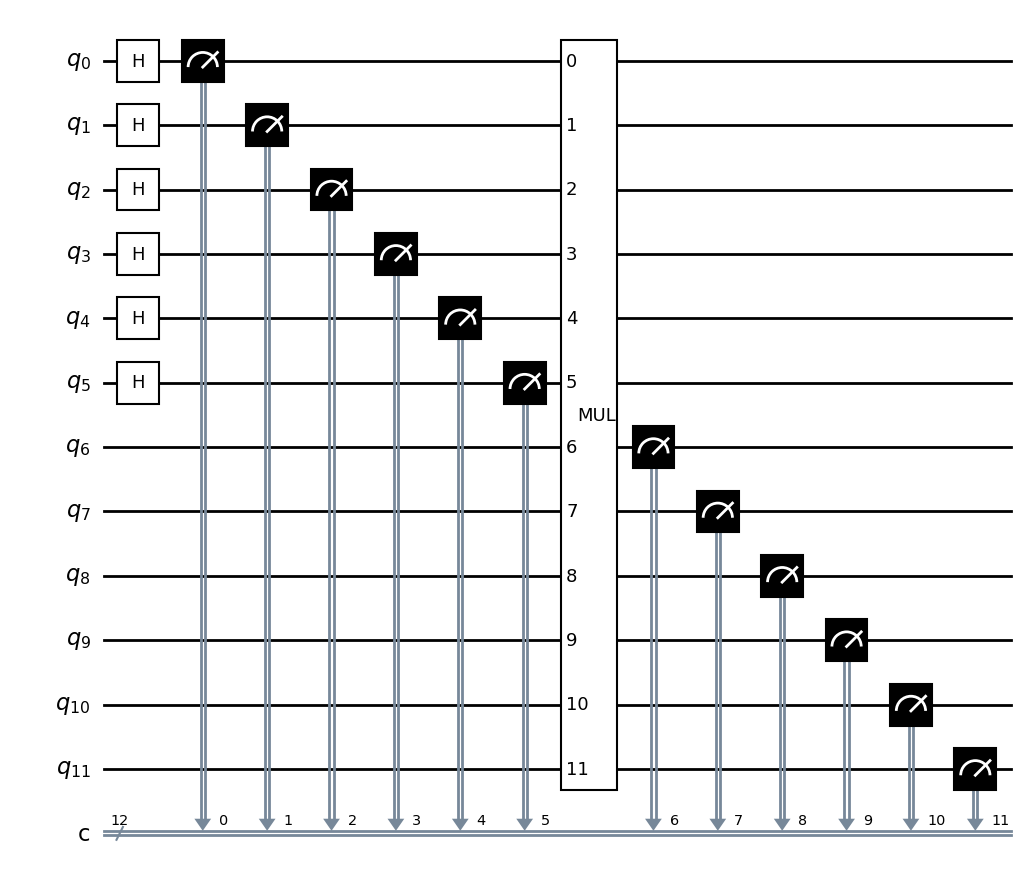

In [37]:
def add_measurements(input_qubits, result_qubits, quantum_circuit):
    
    total_qubits = input_qubits + result_qubits
    
    measured_quantum_circuit = QuantumCircuit(total_qubits, total_qubits)

    # Superposición de los operandos.
    measured_quantum_circuit.h(list(range(input_qubits)))

    # Medición de los valores de los operandos.
    measured_quantum_circuit.measure(list(range(input_qubits)), list(range(input_qubits)))

    measured_quantum_circuit.append(quantum_circuit, list(range(total_qubits)))

    # Se miden los resultados.
    for i in range(input_qubits, total_qubits, 1):
        measured_quantum_circuit.measure(i, i)
        
    return measured_quantum_circuit

measured_quantum_circuit = add_measurements(qubits_in_operands * 2, result_qubits, qc)
measured_quantum_circuit.draw(output='mpl', style='bw')

In [38]:
def simulate(measured_quantum_circuit):
    simulator = AerSimulator()
    transpiled = transpile(measured_quantum_circuit, simulator)
    job = simulator.run(transpiled, shots=10240)
    results = job.result()
    counts = results.get_counts(transpiled)

    histogram = plot_histogram(counts, title="Resultados", color="#1D1A1A")
    histogram.axes[0].set_ylabel("Frecuencia")

    return histogram, counts
    
_, counts = simulate(measured_quantum_circuit)

Guardado: outputs/validacion_mul_parte_1.png


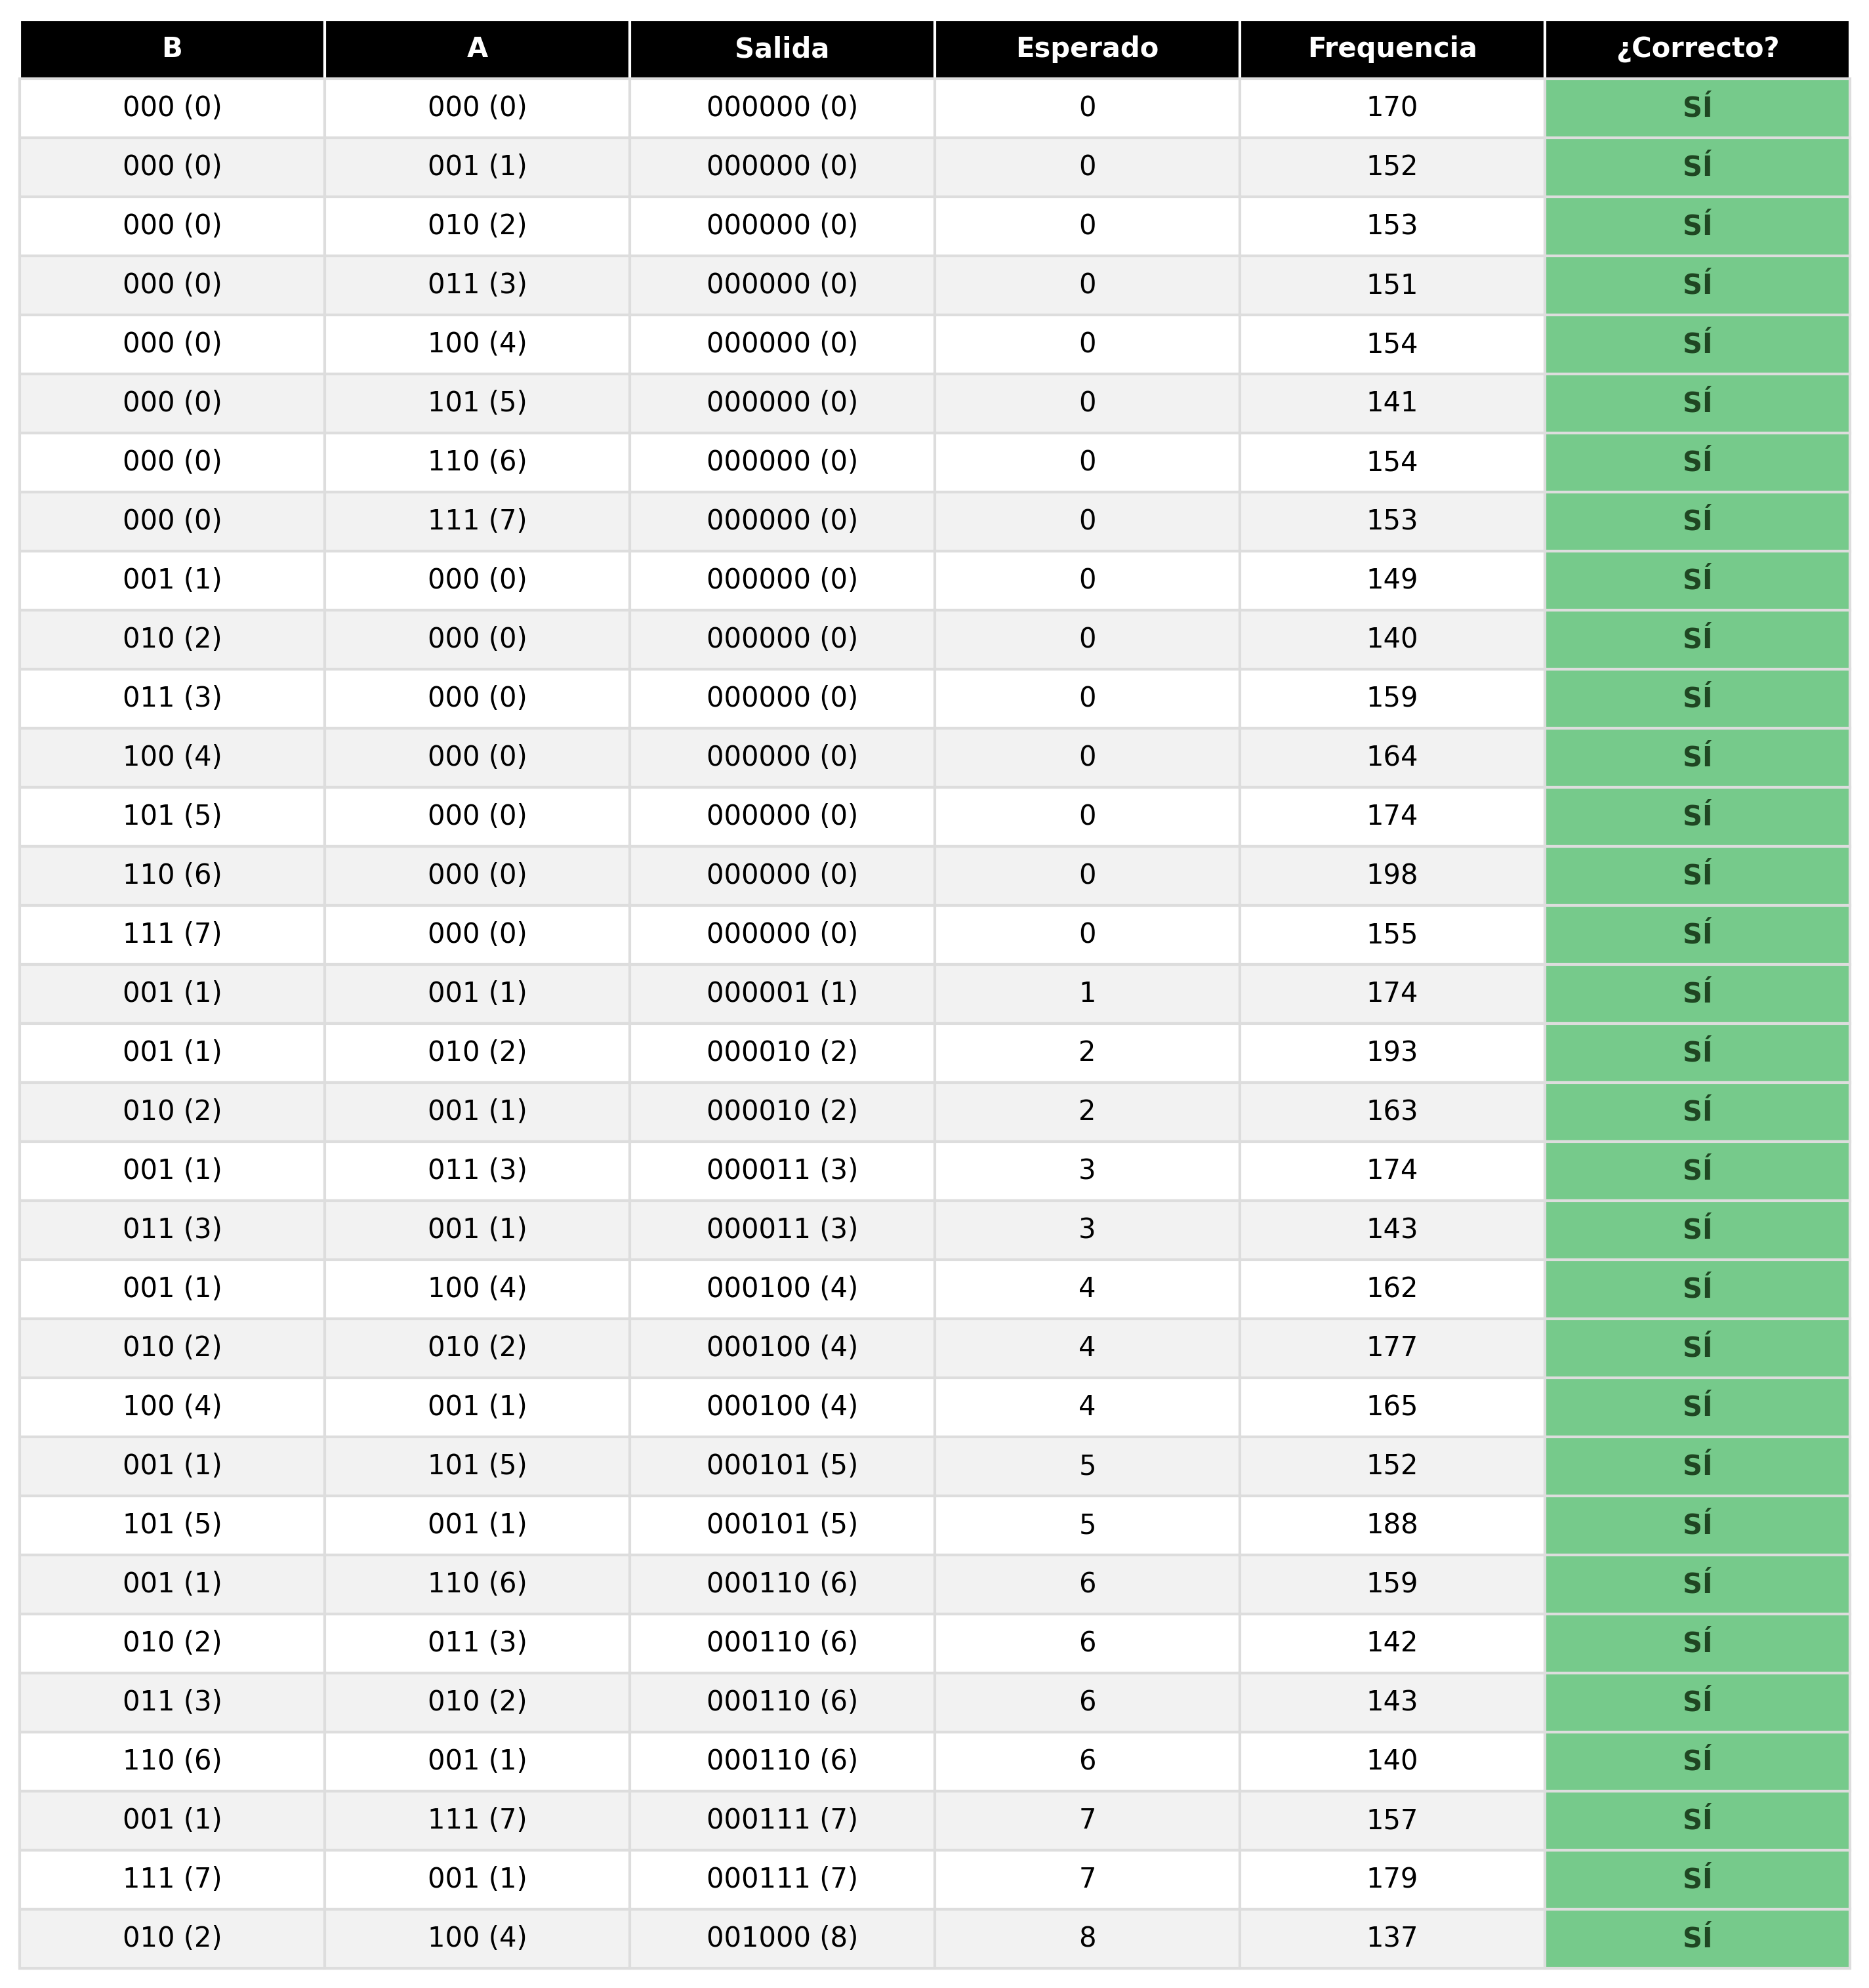

Guardado: outputs/validacion_mul_parte_2.png


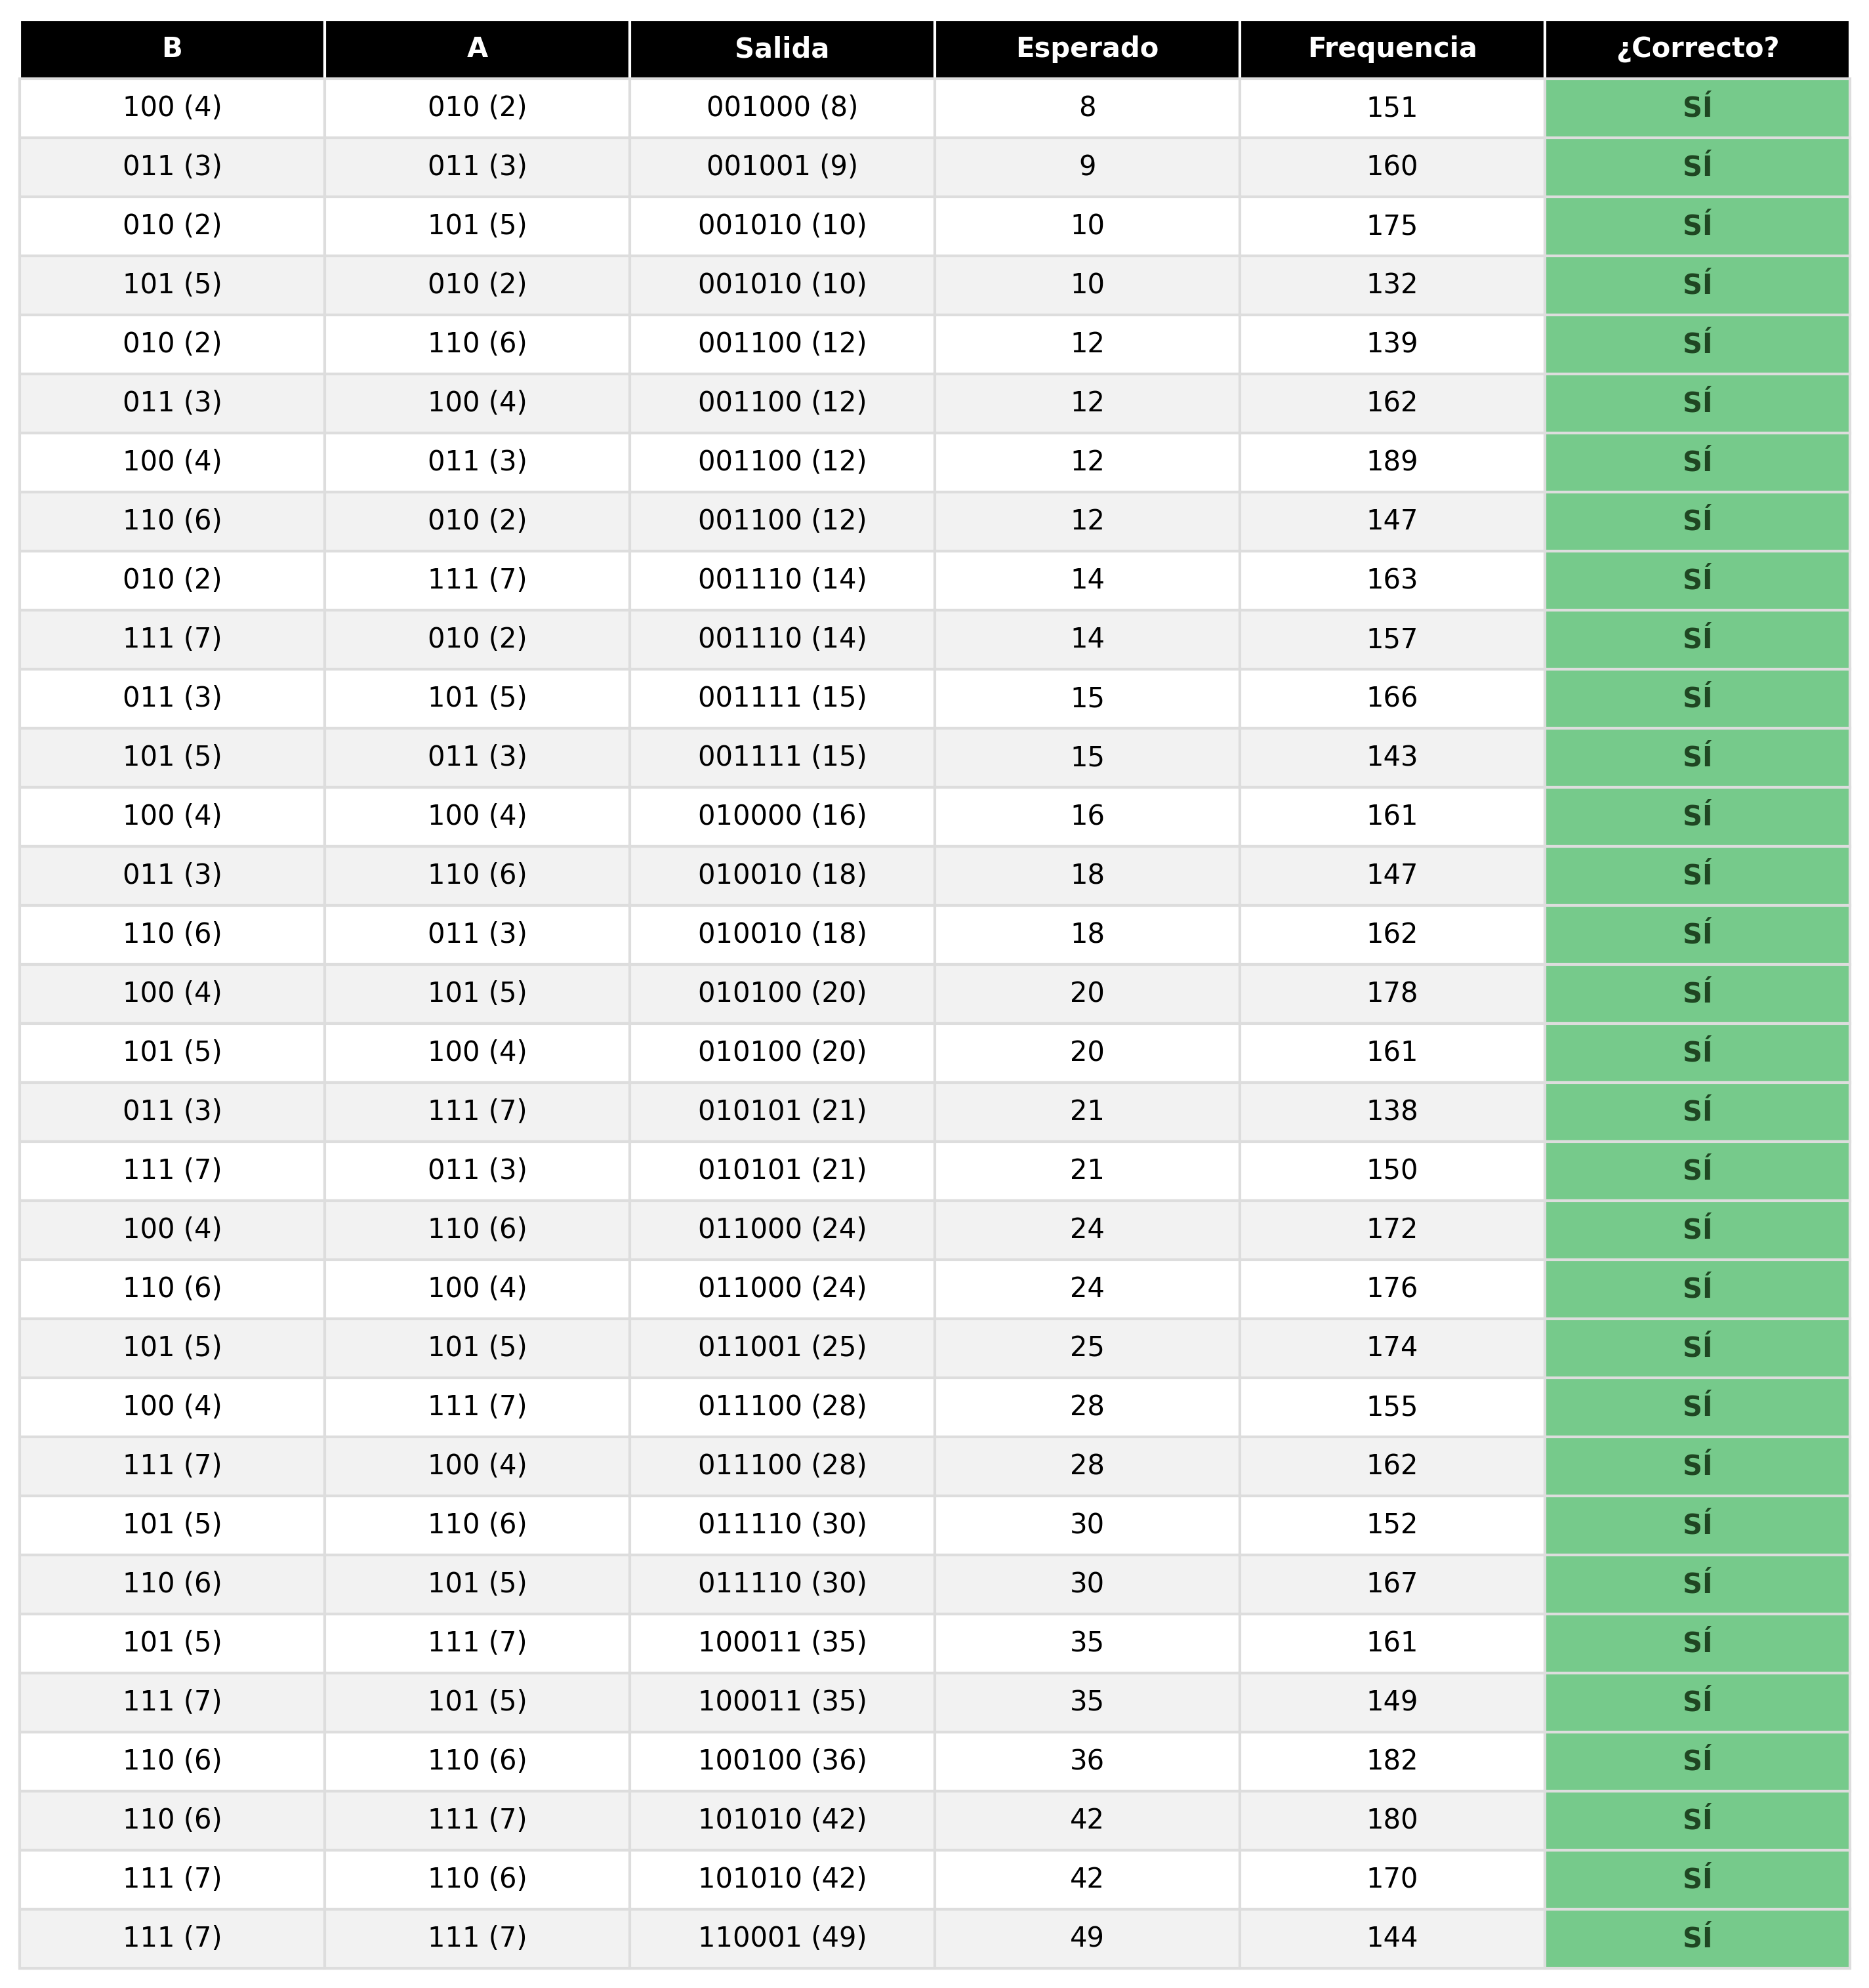

In [39]:


def save_report_table(counts, n_qubits_a, n_qubits_b, n_bits_resultado, filename_base="tabla_mul", max_rows=32):
    """
    Genera múltiples imágenes PNG de alta resolución en la que se presenta una tabla.
    """
    
    # Preparación de los datos.
    data = []
    column_labels = ["B", "A", "Salida", "Esperado", "Frequencia", "¿Correcto?"]
    
    for bitstring, count in sorted(counts.items()):
        clean_bits = bitstring.replace(" ", "")
        
        chars_a = clean_bits[-n_qubits_a:]
        chars_b = clean_bits[-(n_qubits_a + n_qubits_b) : -n_qubits_a]
        chars_out = clean_bits[-(n_qubits_a + n_qubits_b + n_bits_resultado) : -(n_qubits_a + n_qubits_b)]
        
        val_a = int(chars_a, 2)
        val_b = int(chars_b, 2)
        val_real = int(chars_out, 2)
        val_esperado = val_a * val_b
        
        es_correcto = val_esperado == val_real
        status_text = "SÍ" if es_correcto else "NO"
        
        row = [
            f"{chars_b} ({val_b})",
            f"{chars_a} ({val_a})",
            f"{chars_out} ({val_real})",
            val_esperado,
            count,
            status_text
        ]
        data.append(row)

    # Lógica de División (Chunking).
    total_rows = len(data)
    
    # Se calculan cuántas partes se necesitan.
    num_parts = math.ceil(total_rows / max_rows)

    for i in range(num_parts):
        
        # Se definen el inicio y fin del corte.
        start = i * max_rows
        end = start + max_rows
        
        # Se cortan los datos.
        subset_data = data[start:end]
        
        # Generación de la figura para la parte.
        rows_in_subset = len(subset_data)
        fig_height = max(2, rows_in_subset * 0.1) + 1 # +1 para el header.
        
        _, ax = plt.subplots(figsize=(10, fig_height))
        ax.axis('tight')
        ax.axis('off')
        
        # Creación de la tabla.
        table = ax.table(cellText=subset_data, colLabels=column_labels, cellLoc='center', loc='center')
        
        # Estilizado.
        table.auto_set_font_size(False)
        table.set_fontsize(10)
        table.scale(1.2, 1.8) # Un poco más de alto para que respire

        # Coloreado.
        for (r, c), cell in table.get_celld().items():
            if r == 0: # Header.
                cell.set_text_props(weight='bold', color='white')
                cell.set_facecolor("#000000")
                cell.set_edgecolor('white')
            else: # Datos.
                cell.set_edgecolor('#dddddd')
                
                if c == 5: 
                    # Si bien subset_data empieza en 0, la tabla tiene header, por lo que se empieza en r-1.
                    text_val = subset_data[r-1][5]
                    
                    if text_val == "SÍ":
                        cell.set_facecolor("#76CA8B")
                        cell.set_text_props(color="#1F4622", weight='bold')
                    else:
                        cell.set_facecolor('#f8d7da')
                        cell.set_text_props(color='#842029', weight='bold')
                else:
                    if r % 2 == 0:
                        cell.set_facecolor('#f2f2f2')
                    else:
                        cell.set_facecolor('white')
                        
        output_directory = "outputs"
                        
        # Crea el directorio si no existe. 
        # "exist_ok=True" evita el error si ya existe.
        os.makedirs(output_directory, exist_ok=True)

        # Nombre del archivo, especificando la parte.
        current_filename = f"{output_directory}/{filename_base}_parte_{i+1}.png"
        
        # Título.
        # plt.title(f"Tabla de Verdad - Parte {i+1} de {num_parts}", pad=10, fontsize=12, color="#555555")
        
        # Guardado de la tabla en imágenes.
        plt.savefig(current_filename, bbox_inches='tight', dpi=300)
        plt.close()
        
        print(f"Guardado: {current_filename}")
        
        # Se muestra en la notebooks el resultado.
        from IPython.display import display, Image
        display(Image(current_filename))

save_report_table(counts, 3, 3, 6, filename_base="validacion_mul", max_rows=32)